## Import Library

In [1]:
!pip install PySastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 7.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, OrderedDict

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import ComplementNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load Data

In [3]:
data = pd.read_csv('/kaggle/input/indonesian-abusive-and-hate-speech-twitter-text/data.csv', encoding='latin-1')

alay_dict = pd.read_csv('/kaggle/input/indonesian-abusive-and-hate-speech-twitter-text/new_kamusalay.csv', encoding='latin-1', header=None)

id_stopword_dict = pd.read_csv('/kaggle/input/indonesian-stoplist/stopwordbahasa.csv', header=None)
id_stopword_dict = id_stopword_dict.rename(columns={0: 'stopword'})

abusive_dict = pd.read_csv('/kaggle/input/indonesian-abusive-and-hate-speech-twitter-text/abusive.csv')['ABUSIVE'].tolist()

## Data Shape

In [4]:
print("Shape: ", data.shape)
data.head(5)

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [5]:
data.HS.value_counts()

HS
0    7608
1    5561
Name: count, dtype: int64

In [6]:
data.Abusive.value_counts()

Abusive
0    8126
1    5043
Name: count, dtype: int64

In [7]:
print("Toxic shape: ", data[(data['HS'] == 1) | (data['Abusive'] == 1)].shape)
print("Non-toxic shape: ", data[(data['HS'] == 0) & (data['Abusive'] == 0)].shape)

Toxic shape:  (7309, 13)
Non-toxic shape:  (5860, 13)


Alay Dict

In [8]:
print("Shape: ", alay_dict.shape)
alay_dict.head(15)

Shape:  (15167, 2)


,0,1
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


ID Stopword

In [9]:
print("Shape: ", id_stopword_dict.shape)
id_stopword_dict.head()

Shape:  (758, 1)


,stopword
0,ada
1,adalah
2,adanya
3,adapun
4,agak


## Preprocess Data

In [10]:
alay_dict

,0,1
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
...,...,...
15162,mendikbud,menteri pendidikan dan kebudayaan
15163,mendag,menteri perdagangan
15164,menaker,menteri tenaga kerja
15165,memetwit,mentwit


In [11]:
import re
import unicodedata
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text

def remove_unicode(text):
    text = re.sub(r'\bx[a-fA-F0-9]{2}\b', '', text) 
    text = re.sub(r'\bx([a-fA-F0-9]{2})', '', text)
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict[0], alay_dict[1]))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

def remove_stopword(text):
    text = ' '.join(['' if word in id_stopword_dict.stopword.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

def stemming(text):
    return stemmer.stem(text)

def remove_extra_spaces(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

In [12]:
def preprocess(text):
    text = lowercase(text) 
    text = remove_nonaplhanumeric(text) 
    text = remove_unnecessary_char(text) 
    text = normalize_alay(text)
    text = stemming(text) 
    text = remove_stopword(text) 
    text = remove_unicode(text) 
    text = remove_extra_spaces(text) 
    return text

In [13]:
data['Tweet'] = data['Tweet'].apply(preprocess)

In [14]:
print("Shape: ", data.shape)
data.head()

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,cowok usaha lacak perhati gue lantas remeh per...,1,1,1,0,0,0,0,0,1,1,0,0
1,telat tau edan sarap gue gaul cigax jifla cal ...,0,1,0,0,0,0,0,0,0,0,0,0
2,41 kadang pikir percaya tuhan jatuh kali kali ...,0,0,0,0,0,0,0,0,0,0,0,0
3,ku tau mata sipit lihat,0,0,0,0,0,0,0,0,0,0,0,0
4,kaum cebong kafir lihat dongok dungu haha,1,1,0,1,1,0,0,0,0,0,1,0


## EDA

### Most common abusive words

In [15]:
tweets_corpus = [] 

for tweet in data['Tweet'].str.split():
    for word in tweet:
        if len(word) > 0 and word in abusive_dict:
            tweets_corpus.append(word)

In [16]:
counter_tweets = Counter(tweets_corpus).most_common()[:1000]

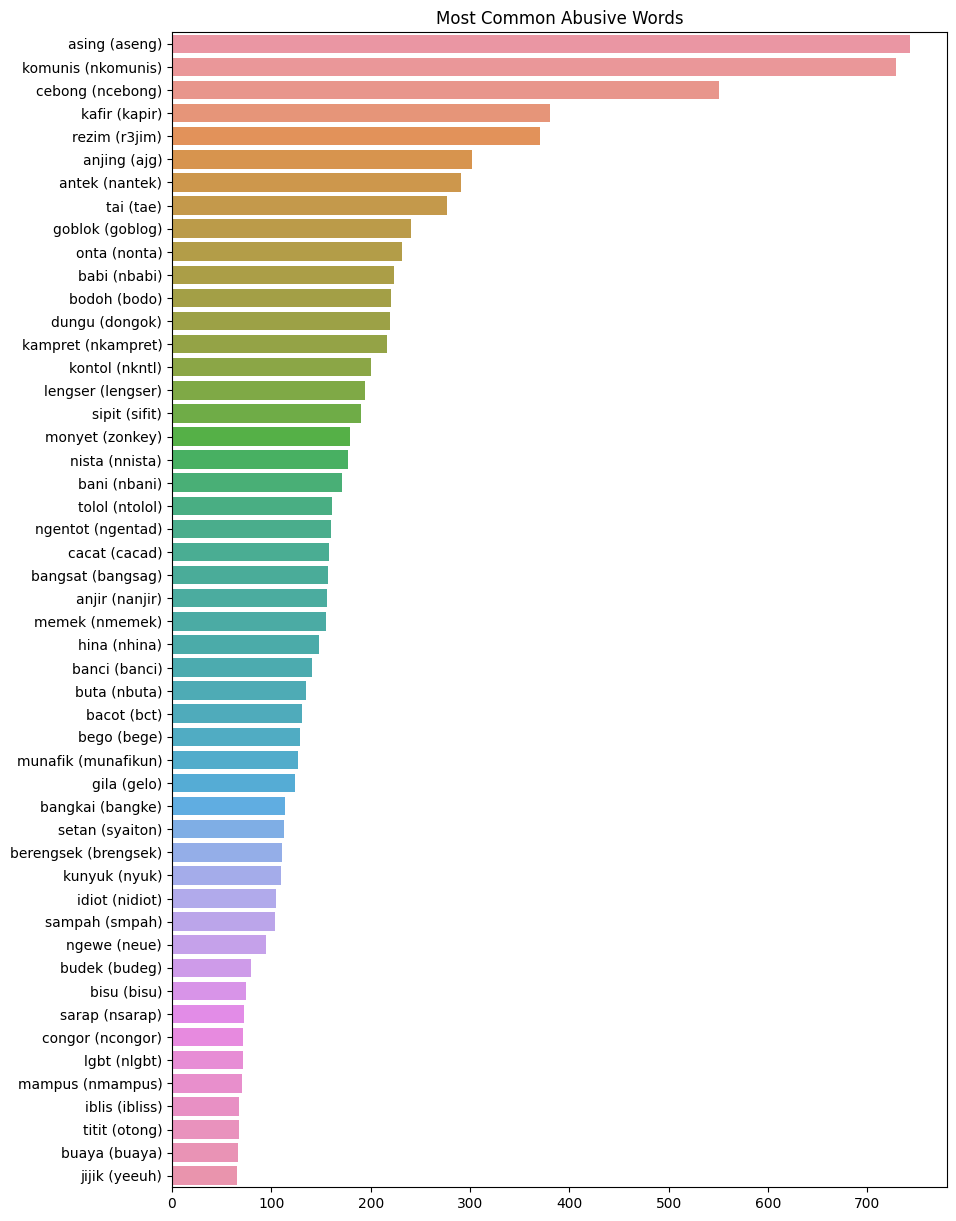

In [17]:
top_tweets = OrderedDict(counter_tweets)

show_only = 50
    
keys = list(top_tweets.keys())
vals = [top_tweets[k] for k in keys]

original_slang = []
for word in keys:
    if word in alay_dict[1].values:
        original_slang.append(alay_dict.loc[alay_dict[1] == word, 0].values[0])
    else:
        original_slang.append(word)
        
combined_words = [f'{keys[i]} ({original_slang[i]})' for i in range(len(keys))]

plt.figure(figsize=(10, 15))
sns.barplot(x=vals[:show_only], y=combined_words[:show_only])
plt.title('Most Common Abusive Words')
plt.show()

### WordCloud

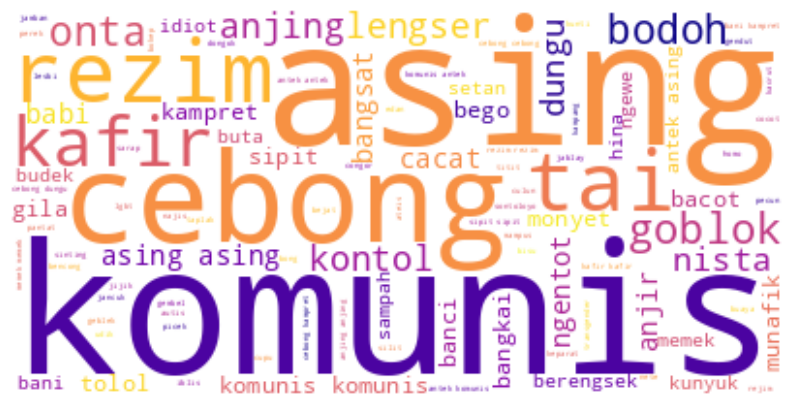

In [18]:
fig, axes = plt.subplots(ncols=1, figsize=(10, 8))
tokens_ = ' '.join(tweets_corpus)
wc_ = WordCloud(max_words=100, background_color='white', max_font_size=100, colormap='plasma').generate(tokens_)
axes.axis("off")
axes.imshow(wc_, interpolation="bilinear")
plt.show()

### Label Distribution

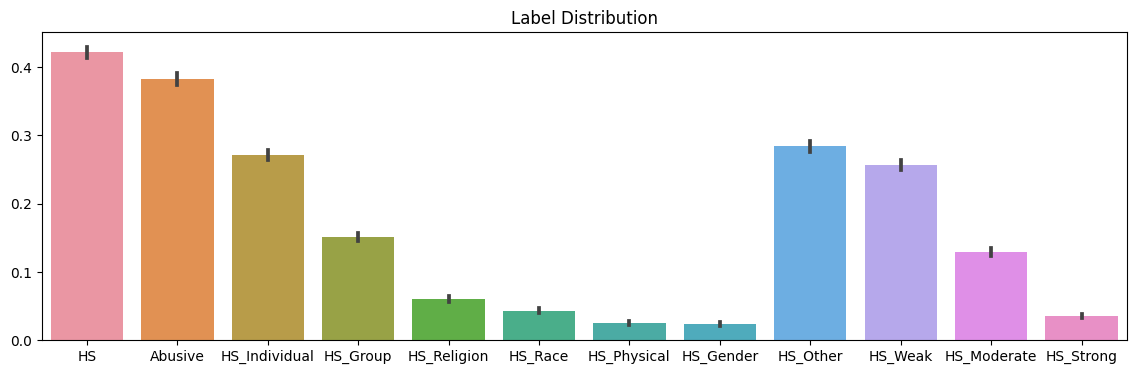

In [19]:
plt.figure(figsize=(14,4))
plt.title('Label Distribution')
sns.barplot(data)
plt.show()

### Count of each label

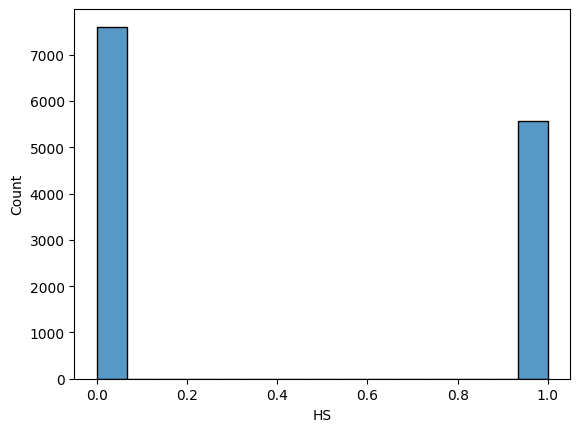

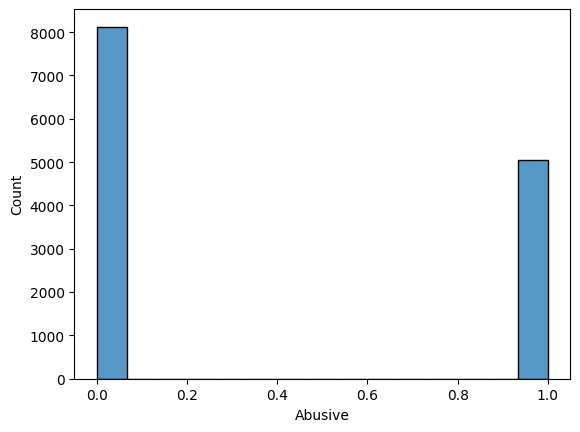

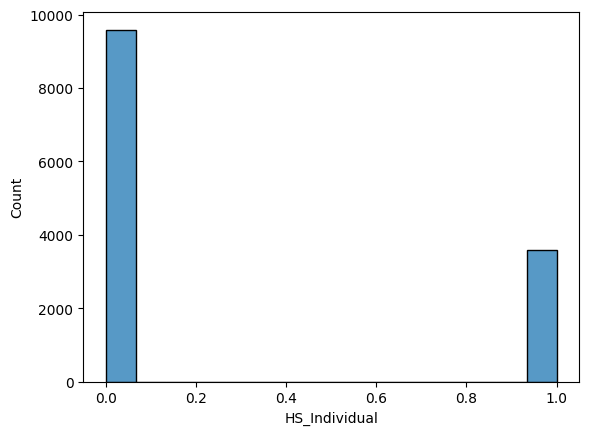

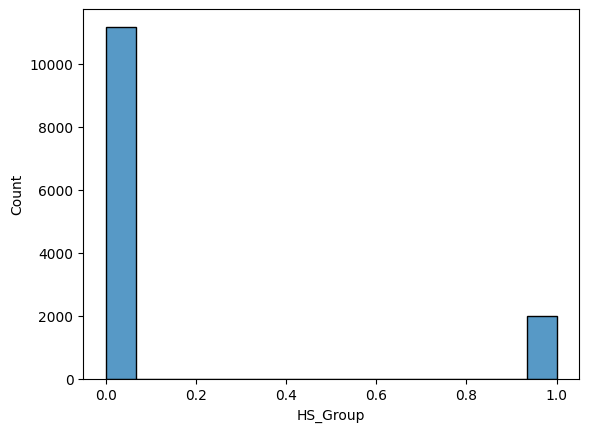

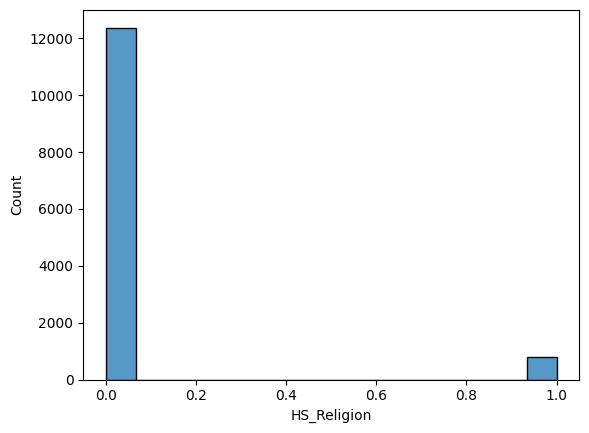

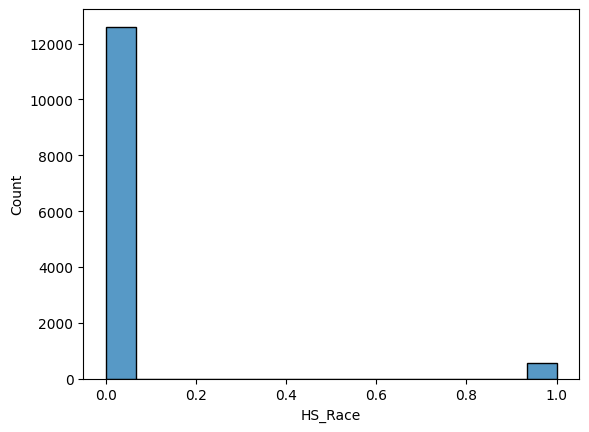

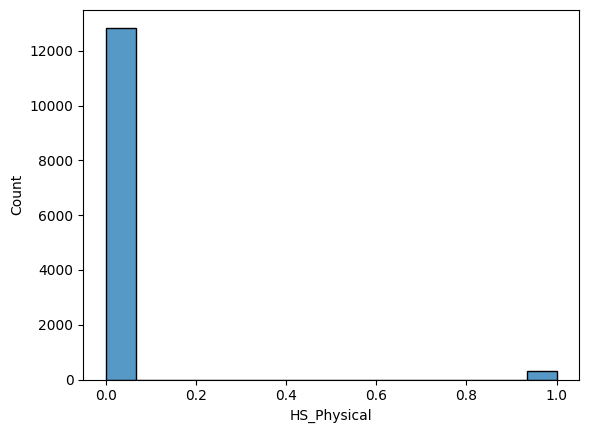

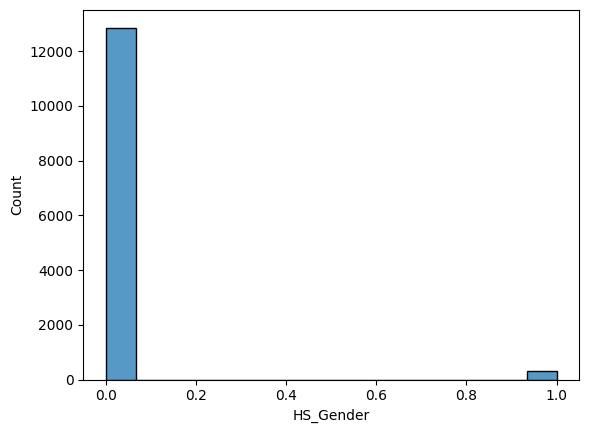

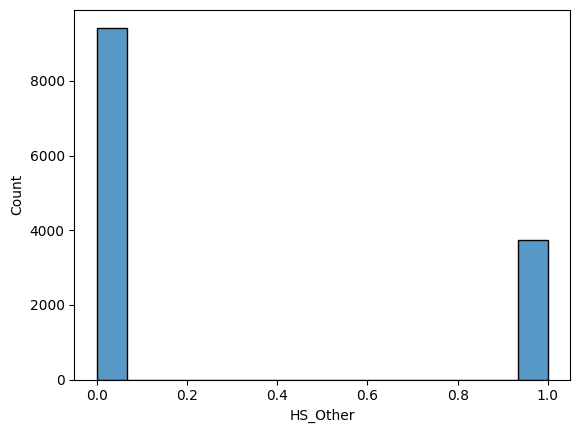

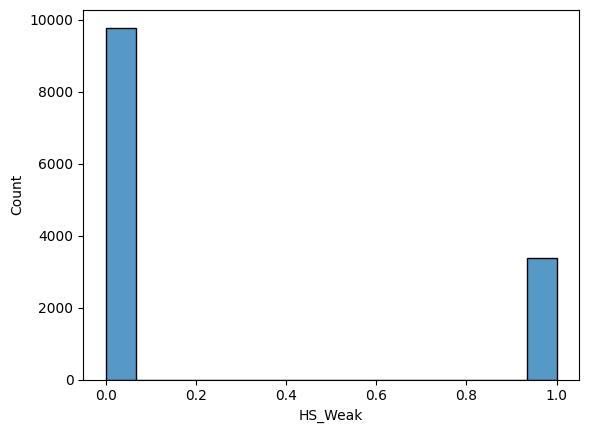

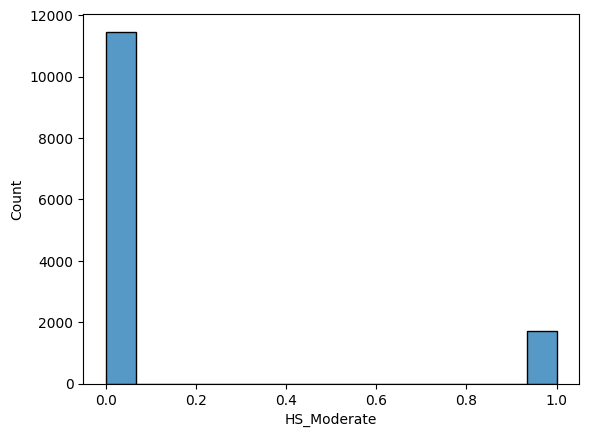

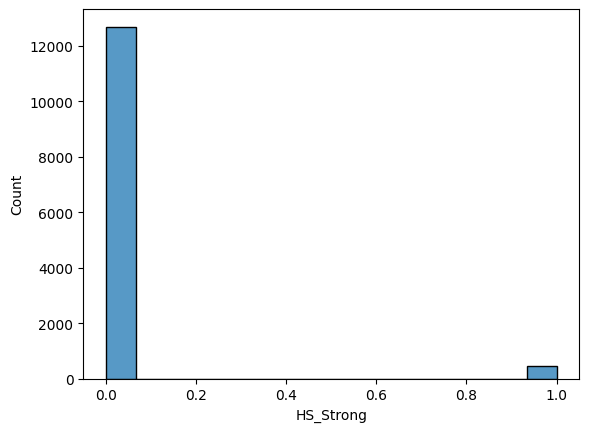

In [20]:
df1 = data.drop(['Tweet'], axis=1)
for i in df1.columns:
    j = 1
    plt.figure(j)
    sns.histplot(data=df1, x=i)
    plt.show()
    j = j+1

### Comments per label

In [21]:
df2 = df1.sum()
df2

HS               5561
Abusive          5043
HS_Individual    3575
HS_Group         1986
HS_Religion       793
HS_Race           566
HS_Physical       323
HS_Gender         306
HS_Other         3740
HS_Weak          3383
HS_Moderate      1705
HS_Strong         473
dtype: int64

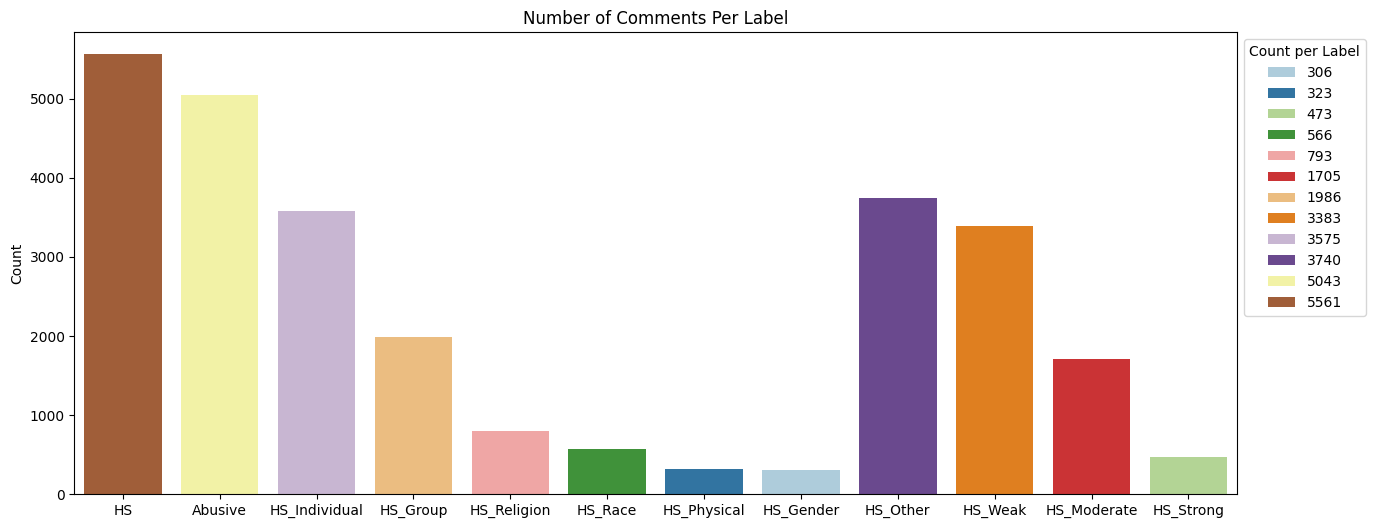

In [22]:
plt.figure(figsize=(15, 6))
sns.barplot(x=df2.index, y=df2.values, hue=df2.values, dodge=False, palette='Paired')
plt.ylabel('Count')
plt.title("Number of Comments Per Label")
leg = plt.legend(title='Count per Label', bbox_to_anchor=(1,1))

## Splitting and Balancing Labels Dataset

Balancing based of comments count per label.

In [23]:
# label dataframe
df_HS = data[['Tweet', 'HS']]
df_Abusive = data[['Tweet', 'Abusive']]
df_Individual = data[['Tweet', 'HS_Individual']]
df_Group = data[['Tweet', 'HS_Group']]
df_Religion = data[['Tweet', 'HS_Religion']]
df_Race = data[['Tweet', 'HS_Race']]
df_Physical = data[['Tweet', 'HS_Physical']]
df_Gender = data[['Tweet', 'HS_Gender']]
df_Other = data[['Tweet', 'HS_Other']]
df_Weak = data[['Tweet', 'HS_Weak']]
df_Moderate = data[['Tweet', 'HS_Moderate']]
df_Strong = data[['Tweet', 'HS_Strong']]

In [24]:
# balancing df_HS 5561
df_HS_1 = df_HS[df_HS['HS'] == 1]
df_HS_0 = df_HS[df_HS['HS'] == 0].iloc[:5561]
df_HS_bal = pd.concat([df_HS_1, df_HS_0], axis=0)
df_HS_bal.shape

(11122, 2)

In [25]:
# balancing df_Abusive 5043
df_Abusive_1 = df_Abusive[df_Abusive['Abusive'] == 1]
df_Abusive_0 = df_Abusive[df_Abusive['Abusive'] == 0].iloc[:5043]
df_Abusive_bal = pd.concat([df_Abusive_1, df_Abusive_0], axis=0)
df_Abusive_bal.shape

(10086, 2)

In [26]:
# balancing df_Individual 3575
df_Individual_1 = df_Individual[df_Individual['HS_Individual'] == 1]
df_Individual_0 = df_Individual[df_Individual['HS_Individual'] == 0].iloc[:3575]
df_Individual_bal = pd.concat([df_Individual_1, df_Individual_0], axis=0)
df_Individual_bal.shape

(7150, 2)

In [27]:
# balancing df_Group 1986
df_Group_1 = df_Group[df_Group['HS_Group'] == 1]
df_Group_0 = df_Group[df_Group['HS_Group'] == 0].iloc[:1986]
df_Group_bal = pd.concat([df_Group_1, df_Group_0], axis=0)
df_Group_bal.shape

(3972, 2)

In [28]:
# balancing df_Religion 793
df_Religion_1 = df_Religion[df_Religion['HS_Religion'] == 1]
df_Religion_0 = df_Religion[df_Religion['HS_Religion'] == 0].iloc[:793]
df_Religion_bal = pd.concat([df_Religion_1, df_Religion_0], axis=0)
df_Religion_bal.shape

(1586, 2)

In [29]:
# balancing df_Race 566
df_Race_1 = df_Race[df_Race['HS_Race'] == 1]
df_Race_0 = df_Race[df_Race['HS_Race'] == 0].iloc[:566]
df_Race_bal = pd.concat([df_Race_1, df_Race_0], axis=0)
df_Race_bal.shape

(1132, 2)

In [30]:
# balancing df_Physical 323
df_Physical_1 = df_Physical[df_Physical['HS_Physical'] == 1]
df_Physical_0 = df_Physical[df_Physical['HS_Physical'] == 0].iloc[:323]
df_Physical_bal = pd.concat([df_Physical_1, df_Physical_0], axis=0)
df_Physical_bal.shape

(646, 2)

In [31]:
# balancing df_Gender 306
df_Gender_1 = df_Gender[df_Gender['HS_Gender'] == 1]
df_Gender_0 = df_Gender[df_Gender['HS_Gender'] == 0].iloc[:306]
df_Gender_bal = pd.concat([df_Gender_1, df_Gender_0], axis=0)
df_Gender_bal.shape

(612, 2)

In [32]:
# balancing df_Other 3740
df_Other_1 = df_Other[df_Other['HS_Other'] == 1]
df_Other_0 = df_Other[df_Other['HS_Other'] == 0].iloc[:3740]
df_Other_bal = pd.concat([df_Other_1, df_Other_0], axis=0)
df_Other_bal.shape

(7480, 2)

In [33]:
# balancing df_Weak 3383
df_Weak_1 = df_Weak[df_Weak['HS_Weak'] == 1]
df_Weak_0 = df_Weak[df_Weak['HS_Weak'] == 0].iloc[:3383]
df_Weak_bal = pd.concat([df_Weak_1, df_Weak_0], axis=0)
df_Weak_bal.shape

(6766, 2)

In [34]:
# balancing df_Moderate 1705
df_Moderate_1 = df_Moderate[df_Moderate['HS_Moderate'] == 1]
df_Moderate_0 = df_Moderate[df_Moderate['HS_Moderate'] == 0].iloc[:1705]
df_Moderate_bal = pd.concat([df_Moderate_1, df_Moderate_0], axis=0)
df_Moderate_bal.shape

(3410, 2)

In [35]:
# balancing df_Strong 473
df_Strong_1 = df_Strong[df_Strong['HS_Strong'] == 1]
df_Strong_0 = df_Strong[df_Strong['HS_Strong'] == 0].iloc[:473]
df_Strong_bal = pd.concat([df_Strong_1, df_Strong_0], axis=0)
df_Strong_bal.shape

(946, 2)

In [36]:
#label dataset
df_HS_bal.to_csv("/kaggle/working/HS.csv")
df_Abusive_bal.to_csv("/kaggle/working/Abusive.csv")
df_Individual_bal.to_csv("/kaggle/working/Individual.csv")
df_Group_bal.to_csv("/kaggle/working/Group.csv")
df_Religion_bal.to_csv("/kaggle/working/Religion.csv")
df_Race_bal.to_csv("/kaggle/working/Race.csv")
df_Physical_bal.to_csv("/kaggle/working/Physical.csv")
df_Gender_bal.to_csv("/kaggle/working/Gender.csv")
df_Other_bal.to_csv("/kaggle/working/Other.csv")
df_Weak_bal.to_csv("/kaggle/working/Weak.csv")
df_Moderate_bal.to_csv("/kaggle/working/Moderate.csv")
df_Strong_bal.to_csv("/kaggle/working/Strong.csv")

## Modelling

In [37]:
def vector_model(data, category, vectorizer, ngram):
    X = data['Tweet'].fillna(' ')
    Y = data[category]

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

    vector = vectorizer(ngram_range=(ngram), stop_words=id_stopword_dict['stopword'].tolist())

    X_train_scal = vector.fit_transform(X_train)
    X_test_scal = vector.transform(X_test)
    
    # KNN
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_scal, Y_train)
    Y_pred_knn = knn.predict(X_test_scal)
    print(f"Knn done -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_knn)} ")
    print("\n----------------------------------------------------------------------")
    
    # logistic regression
    lr = LogisticRegression()
    lr.fit(X_train_scal, Y_train)
    Y_pred_lr = lr.predict(X_test_scal)
    print(f"\nLr done -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_lr)} ")
    print("\n----------------------------------------------------------------------\n")

    # Support Vector Machine
    svm = SVC(kernel='rbf')
    svm.fit(X_train_scal, Y_train)
    Y_pred_svm = svm.predict(X_test_scal)
    print(f"\nsvm done -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_svm)} ")
    print("\n----------------------------------------------------------------------\n")
    
    # Naive Bayes
    cnb = ComplementNB()
    cnb.fit(X_train_scal, Y_train)
    Y_pred_cnb = cnb.predict(X_test_scal)
    print(f"\ncnb done -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_cnb)} ")
    print("\n----------------------------------------------------------------------\n")

    bnb = BernoulliNB()
    bnb.fit(X_train_scal, Y_train)
    Y_pred_bnb = bnb.predict(X_test_scal)
    print(f"\nbnb done -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_bnb)} ")
    print("\n----------------------------------------------------------------------\n")
    
    # Decision Tree Classifier
    dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=2, random_state=42)
    dt.fit(X_train_scal, Y_train)
    Y_pred_dt = dt.predict(X_test_scal)
    print(f"\nDT done -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_dt)} ")
    print("\n----------------------------------------------------------------------\n")

    # Random Forest Classifier
    rf = RandomForestClassifier(n_estimators=105, min_samples_split=2, random_state=42)
    rf.fit(X_train_scal, Y_train)
    Y_pred_rf = rf.predict(X_test_scal)
    print(f"\nRF done -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_rf)} ")
    print("\n----------------------------------------------------------------------\n")
    
    f1_scores = [round(f1_score(Y_pred_knn, Y_test), 2), round(f1_score(Y_pred_lr, Y_test), 2), round(f1_score(Y_pred_svm, Y_test), 2),
                 round(f1_score(Y_pred_cnb, Y_test), 2), round(f1_score(Y_pred_bnb, Y_test), 2), round(f1_score(Y_pred_dt, Y_test), 2),
                 round(f1_score(Y_pred_rf, Y_test), 2)]
    print(f"F1_scores for {category} Are calculated")

    Scores = {f'F1_Score - {category}':f1_scores}
    Scores_data = pd.DataFrame(Scores, index=['KNN', 'Logistic Regression', 'SVM', 'Complement NB', 'Bernoulli NB', 'Decision Tree', 'Random Forest'])
    return Scores_data

## Model Evaluation

### Score for HS

In [38]:
# HS
data_HS = pd.read_csv('/kaggle/working/HS.csv')
result_HS = vector_model(data_HS, 'HS', TfidfVectorizer, (1,1))
result_HS

Knn done -> It's classification report for HS 
               precision    recall  f1-score   support

           0       0.55      0.95      0.70      1664
           1       0.83      0.22      0.35      1673

    accuracy                           0.59      3337
   macro avg       0.69      0.59      0.52      3337
weighted avg       0.69      0.59      0.52      3337
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS 
               precision    recall  f1-score   support

           0       0.80      0.83      0.82      1664
           1       0.83      0.79      0.81      1673

    accuracy                           0.81      3337
   macro avg       0.81      0.81      0.81      3337
weighted avg       0.81      0.81      0.81      3337
 

----------------------------------------------------------------------


svm done -> It's classification report for HS 
               precision    recall  f1-score   support


,F1_Score - HS
KNN,0.35
Logistic Regression,0.81
SVM,0.82
Complement NB,0.82
Bernoulli NB,0.81
Decision Tree,0.78
Random Forest,0.82


### Score for Abusive

In [39]:
# Abusive
data_Abusive = pd.read_csv('/kaggle/working/Abusive.csv')
result_Abusive = vector_model(data_Abusive, 'Abusive', TfidfVectorizer, (1,1))
result_Abusive

Knn done -> It's classification report for Abusive 
               precision    recall  f1-score   support

           0       0.57      0.96      0.72      1477
           1       0.89      0.32      0.47      1549

    accuracy                           0.63      3026
   macro avg       0.73      0.64      0.59      3026
weighted avg       0.74      0.63      0.59      3026
 

----------------------------------------------------------------------

Lr done -> It's classification report for Abusive 
               precision    recall  f1-score   support

           0       0.89      0.90      0.89      1477
           1       0.90      0.89      0.90      1549

    accuracy                           0.90      3026
   macro avg       0.90      0.90      0.90      3026
weighted avg       0.90      0.90      0.90      3026
 

----------------------------------------------------------------------


svm done -> It's classification report for Abusive 
               precision    recall  f1-s

,F1_Score - Abusive
KNN,0.47
Logistic Regression,0.90
SVM,0.91
Complement NB,0.88
Bernoulli NB,0.85
Decision Tree,0.87
Random Forest,0.89


### Score for HS_Individual

In [40]:
# Individual
data_Individual = pd.read_csv('/kaggle/working/Individual.csv')
result_Individual = vector_model(data_Individual, 'HS_Individual', TfidfVectorizer, (1,1))
result_Individual

Knn done -> It's classification report for HS_Individual 
               precision    recall  f1-score   support

           0       0.54      0.95      0.69      1042
           1       0.84      0.24      0.38      1103

    accuracy                           0.59      2145
   macro avg       0.69      0.60      0.53      2145
weighted avg       0.69      0.59      0.53      2145
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Individual 
               precision    recall  f1-score   support

           0       0.77      0.81      0.79      1042
           1       0.81      0.77      0.79      1103

    accuracy                           0.79      2145
   macro avg       0.79      0.79      0.79      2145
weighted avg       0.79      0.79      0.79      2145
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Individual 
               precisi

,F1_Score - HS_Individual
KNN,0.38
Logistic Regression,0.79
SVM,0.80
Complement NB,0.80
Bernoulli NB,0.78
Decision Tree,0.74
Random Forest,0.79


### Score for HS_Group

In [41]:
# Group
data_Group = pd.read_csv('/kaggle/working/Group.csv')
result_Group = vector_model(data_Group, 'HS_Group', TfidfVectorizer, (1,1))
result_Group

Knn done -> It's classification report for HS_Group 
               precision    recall  f1-score   support

           0       0.52      0.99      0.68       578
           1       0.93      0.15      0.26       614

    accuracy                           0.56      1192
   macro avg       0.73      0.57      0.47      1192
weighted avg       0.73      0.56      0.47      1192
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Group 
               precision    recall  f1-score   support

           0       0.75      0.84      0.79       578
           1       0.83      0.73      0.78       614

    accuracy                           0.78      1192
   macro avg       0.79      0.79      0.78      1192
weighted avg       0.79      0.78      0.78      1192
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Group 
               precision    recall  f

,F1_Score - HS_Group
KNN,0.26
Logistic Regression,0.78
SVM,0.79
Complement NB,0.79
Bernoulli NB,0.80
Decision Tree,0.75
Random Forest,0.79


### Score for HS_Religion

In [42]:
# Religion
data_Religion = pd.read_csv('/kaggle/working/Religion.csv')
result_Religion = vector_model(data_Religion, 'HS_Religion', TfidfVectorizer, (1,1))
result_Religion

Knn done -> It's classification report for HS_Religion 
               precision    recall  f1-score   support

           0       0.53      1.00      0.69       240
           1       0.96      0.09      0.17       236

    accuracy                           0.55       476
   macro avg       0.74      0.54      0.43       476
weighted avg       0.74      0.55      0.43       476
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Religion 
               precision    recall  f1-score   support

           0       0.85      0.90      0.88       240
           1       0.90      0.83      0.86       236

    accuracy                           0.87       476
   macro avg       0.87      0.87      0.87       476
weighted avg       0.87      0.87      0.87       476
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Religion 
               precision    

,F1_Score - HS_Religion
KNN,0.17
Logistic Regression,0.86
SVM,0.85
Complement NB,0.83
Bernoulli NB,0.87
Decision Tree,0.86
Random Forest,0.88


### Score for HS_Race

In [43]:
# Race
data_Race = pd.read_csv('/kaggle/working/Race.csv')
result_Race = vector_model(data_Race, 'HS_Race', TfidfVectorizer, (1,1))
result_Race

Knn done -> It's classification report for HS_Race 
               precision    recall  f1-score   support

           0       0.49      1.00      0.66       158
           1       1.00      0.09      0.17       182

    accuracy                           0.51       340
   macro avg       0.74      0.55      0.41       340
weighted avg       0.76      0.51      0.40       340
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Race 
               precision    recall  f1-score   support

           0       0.91      0.92      0.92       158
           1       0.93      0.92      0.93       182

    accuracy                           0.92       340
   macro avg       0.92      0.92      0.92       340
weighted avg       0.92      0.92      0.92       340
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Race 
               precision    recall  f1-s

,F1_Score - HS_Race
KNN,0.17
Logistic Regression,0.93
SVM,0.93
Complement NB,0.88
Bernoulli NB,0.90
Decision Tree,0.94
Random Forest,0.94


### Score for HS_Physical

In [44]:
# Physical
data_Physical = pd.read_csv('/kaggle/working/Physical.csv')
result_Physical = vector_model(data_Physical, 'HS_Physical', TfidfVectorizer, (1,1))
result_Physical

Knn done -> It's classification report for HS_Physical 
               precision    recall  f1-score   support

           0       0.49      1.00      0.66        88
           1       1.00      0.13      0.23       106

    accuracy                           0.53       194
   macro avg       0.74      0.57      0.45       194
weighted avg       0.77      0.53      0.43       194
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Physical 
               precision    recall  f1-score   support

           0       0.71      0.83      0.76        88
           1       0.84      0.72      0.77       106

    accuracy                           0.77       194
   macro avg       0.77      0.77      0.77       194
weighted avg       0.78      0.77      0.77       194
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Physical 
               precision    

,F1_Score - HS_Physical
KNN,0.23
Logistic Regression,0.77
SVM,0.77
Complement NB,0.84
Bernoulli NB,0.81
Decision Tree,0.88
Random Forest,0.85


### Score for HS_Gender

In [45]:
# Gender
data_Gender = pd.read_csv('/kaggle/working/Gender.csv')
result_Gender = vector_model(data_Gender, 'HS_Gender', TfidfVectorizer, (1,1))
result_Gender

Knn done -> It's classification report for HS_Gender 
               precision    recall  f1-score   support

           0       0.46      1.00      0.63        80
           1       1.00      0.09      0.16       104

    accuracy                           0.48       184
   macro avg       0.73      0.54      0.39       184
weighted avg       0.76      0.48      0.36       184
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Gender 
               precision    recall  f1-score   support

           0       0.77      0.79      0.78        80
           1       0.83      0.82      0.83       104

    accuracy                           0.80       184
   macro avg       0.80      0.80      0.80       184
weighted avg       0.81      0.80      0.80       184
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Gender 
               precision    recall

,F1_Score - HS_Gender
KNN,0.16
Logistic Regression,0.83
SVM,0.80
Complement NB,0.84
Bernoulli NB,0.85
Decision Tree,0.88
Random Forest,0.84


### Score for HS_Other

In [46]:
# Other
data_Other = pd.read_csv('/kaggle/working/Other.csv')
result_Other = vector_model(data_Other, 'HS_Other', TfidfVectorizer, (1,1))
result_Other

Knn done -> It's classification report for HS_Other 
               precision    recall  f1-score   support

           0       0.79      0.20      0.32      1118
           1       0.54      0.95      0.69      1126

    accuracy                           0.58      2244
   macro avg       0.67      0.57      0.51      2244
weighted avg       0.67      0.58      0.51      2244
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Other 
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      1118
           1       0.84      0.85      0.84      1126

    accuracy                           0.84      2244
   macro avg       0.84      0.84      0.84      2244
weighted avg       0.84      0.84      0.84      2244
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Other 
               precision    recall  f

,F1_Score - HS_Other
KNN,0.69
Logistic Regression,0.84
SVM,0.84
Complement NB,0.84
Bernoulli NB,0.82
Decision Tree,0.77
Random Forest,0.83


### Score for HS_Weak

In [47]:
# Weak
data_Weak = pd.read_csv('/kaggle/working/Weak.csv')
result_Weak = vector_model(data_Weak, 'HS_Weak', TfidfVectorizer, (1,1))
result_Weak

Knn done -> It's classification report for HS_Weak 
               precision    recall  f1-score   support

           0       0.55      0.92      0.69       995
           1       0.78      0.27      0.40      1035

    accuracy                           0.59      2030
   macro avg       0.66      0.60      0.54      2030
weighted avg       0.67      0.59      0.54      2030
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Weak 
               precision    recall  f1-score   support

           0       0.77      0.78      0.77       995
           1       0.78      0.77      0.78      1035

    accuracy                           0.78      2030
   macro avg       0.78      0.78      0.78      2030
weighted avg       0.78      0.78      0.78      2030
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Weak 
               precision    recall  f1-s

,F1_Score - HS_Weak
KNN,0.40
Logistic Regression,0.78
SVM,0.78
Complement NB,0.78
Bernoulli NB,0.77
Decision Tree,0.74
Random Forest,0.78


### Score for HS_Moderate

In [48]:
# Moderate
data_Moderate = pd.read_csv('/kaggle/working/Moderate.csv')
result_Moderate = vector_model(data_Moderate, 'HS_Moderate', TfidfVectorizer, (1,1))
result_Moderate

Knn done -> It's classification report for HS_Moderate 
               precision    recall  f1-score   support

           0       0.51      0.95      0.66       502
           1       0.71      0.12      0.20       521

    accuracy                           0.52      1023
   macro avg       0.61      0.53      0.43      1023
weighted avg       0.61      0.52      0.43      1023
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Moderate 
               precision    recall  f1-score   support

           0       0.73      0.80      0.76       502
           1       0.78      0.71      0.75       521

    accuracy                           0.75      1023
   macro avg       0.76      0.75      0.75      1023
weighted avg       0.76      0.75      0.75      1023
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Moderate 
               precision    

,F1_Score - HS_Moderate
KNN,0.20
Logistic Regression,0.75
SVM,0.74
Complement NB,0.77
Bernoulli NB,0.78
Decision Tree,0.70
Random Forest,0.75


### Score for HS_Strong

In [49]:
# Strong
data_Strong = pd.read_csv('/kaggle/working/Strong.csv')
result_Strong = vector_model(data_Strong, 'HS_Strong', TfidfVectorizer, (1,1))
result_Strong

Knn done -> It's classification report for HS_Strong 
               precision    recall  f1-score   support

           0       0.59      0.99      0.74       144
           1       0.98      0.29      0.44       140

    accuracy                           0.64       284
   macro avg       0.78      0.64      0.59       284
weighted avg       0.78      0.64      0.59       284
 

----------------------------------------------------------------------

Lr done -> It's classification report for HS_Strong 
               precision    recall  f1-score   support

           0       0.88      0.93      0.90       144
           1       0.92      0.86      0.89       140

    accuracy                           0.90       284
   macro avg       0.90      0.90      0.90       284
weighted avg       0.90      0.90      0.90       284
 

----------------------------------------------------------------------


svm done -> It's classification report for HS_Strong 
               precision    recall

,F1_Score - HS_Strong
KNN,0.44
Logistic Regression,0.89
SVM,0.90
Complement NB,0.84
Bernoulli NB,0.86
Decision Tree,0.88
Random Forest,0.90


### F1-score for All Labels

In [50]:
# Visualization of F1-Score of all categories
result = pd.concat([result_HS, result_Abusive, result_Individual, result_Group, result_Religion, result_Race, result_Physical, result_Gender, result_Other, result_Weak, result_Moderate, result_Strong], axis=1)
result = result.transpose()
result.head(12)

,KNN,Logistic Regression,SVM,Complement NB,Bernoulli NB,Decision Tree,Random Forest
F1_Score - HS,0.35,0.81,0.82,0.82,0.81,0.78,0.82
F1_Score - Abusive,0.47,0.90,0.91,0.88,0.85,0.87,0.89
F1_Score - HS_Individual,0.38,0.79,0.80,0.80,0.78,0.74,0.79
F1_Score - HS_Group,0.26,0.78,0.79,0.79,0.80,0.75,0.79
F1_Score - HS_Religion,0.17,0.86,0.85,0.83,0.87,0.86,0.88
F1_Score - HS_Race,0.17,0.93,0.93,0.88,0.90,0.94,0.94
F1_Score - HS_Physical,0.23,0.77,0.77,0.84,0.81,0.88,0.85
F1_Score - HS_Gender,0.16,0.83,0.80,0.84,0.85,0.88,0.84
F1_Score - HS_Other,0.69,0.84,0.84,0.84,0.82,0.77,0.83
F1_Score - HS_Weak,0.40,0.78,0.78,0.78,0.77,0.74,0.78


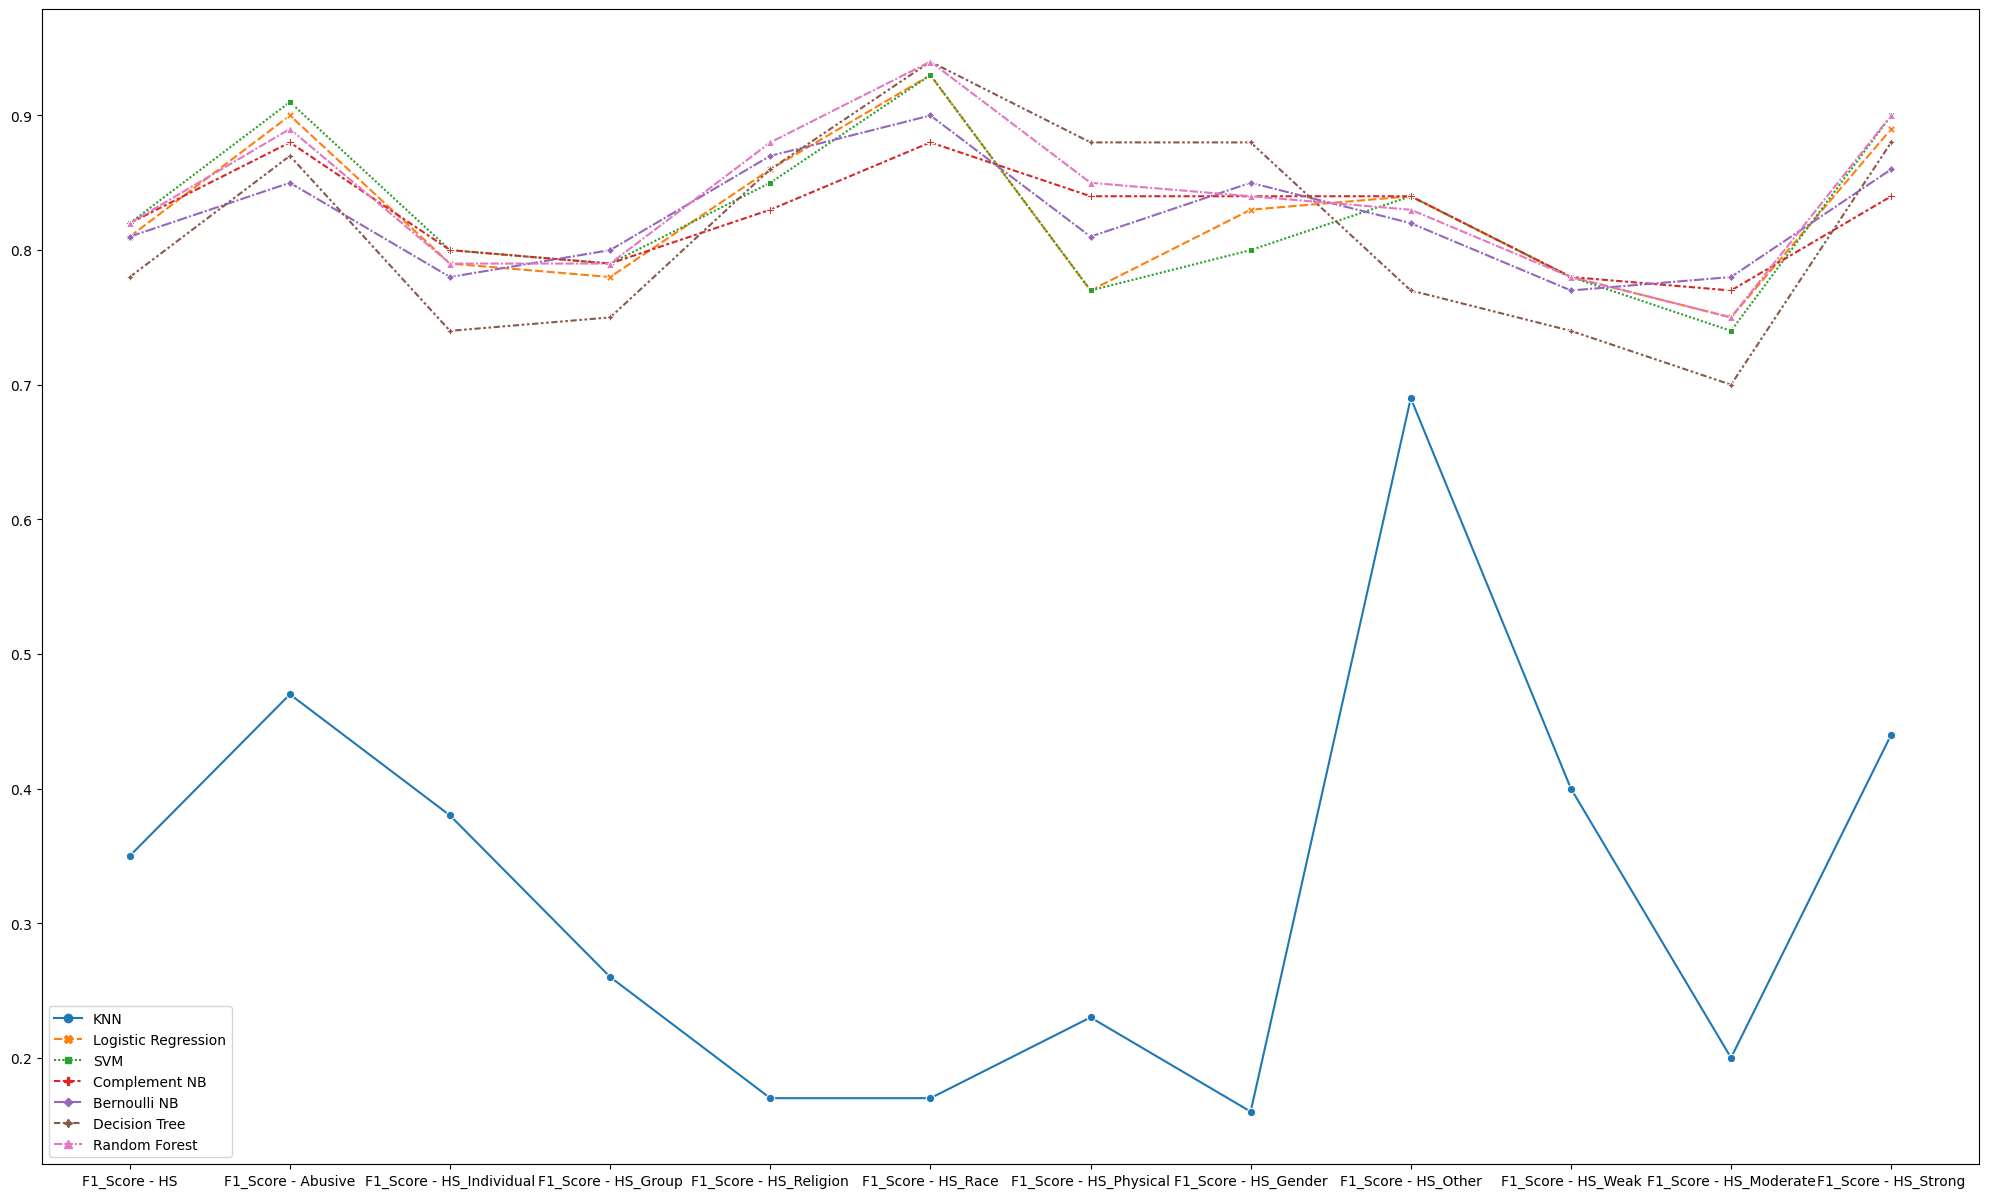

In [51]:
plt.figure(figsize=(25,15))
sns.lineplot(data=result, markers=True)
plt.legend(loc='best')

## Prediction - picking logistic regression model from above graph

In [52]:
example1 = ['Wahyu goblok gabisa mimpin negara gimana indonesia mau maju tolol anjing']

### HS

In [53]:
x = df_HS.Tweet.fillna(' ')
y = df_HS['HS']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
tfvHS = TfidfVectorizer(ngram_range=(1,1), stop_words=id_stopword_dict['stopword'].tolist())
x_train_scal = tfvHS.fit_transform(x_train)
x_test_scal = tfvHS.transform(x_test)
lrHS = LogisticRegression()
lrHS.fit(x_train_scal, y_train)
lrHS.predict(x_test_scal)[:100]

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0])

In [54]:
example1_preprocessed = [preprocess(text) for text in example1]
example1_transform = tfvHS.transform(example1_preprocessed)
zero=lrHS.predict_proba(example1_transform)[:,0][0]
one=lrHS.predict_proba(example1_transform)[:,1][0]
if (zero>=0.42 and one<=0.58) and (zero<=0.58 and one>=0.42):
    print('Neutral')
elif one>0.58:
    print('HS')
else: 
    print('Not HS')

HS


### Abusive

In [55]:
x = df_Abusive.Tweet.fillna(' ')
y = df_Abusive['Abusive']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
tfvAbusive = TfidfVectorizer(ngram_range=(1,1), stop_words=id_stopword_dict['stopword'].tolist())
x_train_scal = tfvAbusive.fit_transform(x_train)
x_test_scal = tfvAbusive.transform(x_test)
lrAbusive = LogisticRegression()
lrAbusive.fit(x_train_scal, y_train)
lrAbusive.predict(x_test_scal)[:100]

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0])

In [56]:
example1_preprocessed = [preprocess(text) for text in example1]
example1_transform = tfvAbusive.transform(example1_preprocessed)
zero=lrAbusive.predict_proba(example1_transform)[:,0][0]
one=lrAbusive.predict_proba(example1_transform)[:,1][0]
if (zero>=0.42 and one<=0.58) and (zero<=0.58 and one>=0.42):
    print('Neutral')
elif one>0.58:
    print('Abusive')
else: 
    print('Not Abusive')

Abusive


### HS_Individual

In [57]:
x = df_Individual.Tweet.fillna(' ')
y = df_Individual['HS_Individual']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
tfvIndividual = TfidfVectorizer(ngram_range=(1,1), stop_words=id_stopword_dict['stopword'].tolist())
x_train_scal = tfvIndividual.fit_transform(x_train)
x_test_scal = tfvIndividual.transform(x_test)
lrIndividual = LogisticRegression()
lrIndividual.fit(x_train_scal, y_train)
lrIndividual.predict(x_test_scal)[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0])

In [58]:
example1_preprocessed = [preprocess(text) for text in example1]
example1_transform = tfvIndividual.transform(example1_preprocessed)
zero=lrIndividual.predict_proba(example1_transform)[:,0][0]
one=lrIndividual.predict_proba(example1_transform)[:,1][0]
if (zero>=0.42 and one<=0.58) and (zero<=0.58 and one>=0.42):
    print('Neutral')
elif one>0.58:
    print('HS_Individual')
else: 
    print('Not HS_Individual')

HS_Individual


### HS_Group

In [59]:
x = df_Group.Tweet.fillna(' ')
y = df_Group['HS_Group']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
tfvGroup = TfidfVectorizer(ngram_range=(1,1), stop_words=id_stopword_dict['stopword'].tolist())
x_train_scal = tfvGroup.fit_transform(x_train)
x_test_scal = tfvGroup.transform(x_test)
lrGroup = LogisticRegression()
lrGroup.fit(x_train_scal, y_train)
lrGroup.predict(x_test_scal)[:100]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [60]:
example1_preprocessed = [preprocess(text) for text in example1]
example1_transform = tfvGroup.transform(example1_preprocessed)
zero=lrGroup.predict_proba(example1_transform)[:,0][0]
one=lrGroup.predict_proba(example1_transform)[:,1][0]
if (zero>=0.42 and one<=0.58) and (zero<=0.58 and one>=0.42):
    print('Neutral')
elif one>0.58:
    print('HS_Group')
else: 
    print('Not HS_Group')

Not HS_Group


### HS_Religion

In [61]:
x = df_Religion.Tweet.fillna(' ')
y = df_Religion['HS_Religion']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
tfvReligion = TfidfVectorizer(ngram_range=(1,1), stop_words=id_stopword_dict['stopword'].tolist())
x_train_scal = tfvReligion.fit_transform(x_train)
x_test_scal = tfvReligion.transform(x_test)
lrReligion = LogisticRegression()
lrReligion.fit(x_train_scal, y_train)
lrReligion.predict(x_test_scal)[:100]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [62]:
example1_preprocessed = [preprocess(text) for text in example1]
example1_transform = tfvReligion.transform(example1_preprocessed)
zero=lrReligion.predict_proba(example1_transform)[:,0][0]
one=lrReligion.predict_proba(example1_transform)[:,1][0]
if (zero>=0.42 and one<=0.58) and (zero<=0.58 and one>=0.42):
    print('Neutral')
elif one>0.58:
    print('HS_Religion')
else: 
    print('Not HS_Religion')

Not HS_Religion


### HS_Race

In [63]:
x = df_Race.Tweet.fillna(' ')
y = df_Race['HS_Race']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
tfvRace = TfidfVectorizer(ngram_range=(1,1), stop_words=id_stopword_dict['stopword'].tolist())
x_train_scal = tfvRace.fit_transform(x_train)
x_test_scal = tfvRace.transform(x_test)
lrRace = LogisticRegression()
lrRace.fit(x_train_scal, y_train)
lrRace.predict(x_test_scal)[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [64]:
example1_preprocessed = [preprocess(text) for text in example1]
example1_transform = tfvRace.transform(example1_preprocessed)
zero=lrRace.predict_proba(example1_transform)[:,0][0]
one=lrRace.predict_proba(example1_transform)[:,1][0]
if (zero>=0.42 and one<=0.58) and (zero<=0.58 and one>=0.42):
    print('Neutral')
elif one>0.58:
    print('HS_Race')
else: 
    print('Not HS_Race')

Not HS_Race


### HS_Gender

In [65]:
x = df_Gender.Tweet.fillna(' ')
y = df_Gender['HS_Gender']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
tfvGender = TfidfVectorizer(ngram_range=(1,1), stop_words=id_stopword_dict['stopword'].tolist())
x_train_scal = tfvGender.fit_transform(x_train)
x_test_scal = tfvGender.transform(x_test)
lrGender = LogisticRegression()
lrGender.fit(x_train_scal, y_train)
lrGender.predict(x_test_scal)[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [66]:
example1_preprocessed = [preprocess(text) for text in example1]
example1_transform = tfvGender.transform(example1_preprocessed)
zero=lrGender.predict_proba(example1_transform)[:,0][0]
one=lrGender.predict_proba(example1_transform)[:,1][0]
if (zero>=0.42 and one<=0.58) and (zero<=0.58 and one>=0.42):
    print('Neutral')
elif one>0.58:
    print('HS_Gender')
else: 
    print('Not HS_Gender')

Not HS_Gender


### HS_Other

In [67]:
x = df_Other.Tweet.fillna(' ')
y = df_Other['HS_Other']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
tfvOther = TfidfVectorizer(ngram_range=(1,1), stop_words=id_stopword_dict['stopword'].tolist())
x_train_scal = tfvOther.fit_transform(x_train)
x_test_scal = tfvOther.transform(x_test)
lrOther = LogisticRegression()
lrOther.fit(x_train_scal, y_train)
lrOther.predict(x_test_scal)[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [68]:
example1_preprocessed = [preprocess(text) for text in example1]
example1_transform = tfvOther.transform(example1_preprocessed)
zero=lrOther.predict_proba(example1_transform)[:,0][0]
one=lrOther.predict_proba(example1_transform)[:,1][0]
if (zero>=0.42 and one<=0.58) and (zero<=0.58 and one>=0.42):
    print('Neutral')
elif one>0.58:
    print('HS_Other')
else: 
    print('Not HS_Other')

HS_Other


### HS_Weak

In [69]:
x = df_Weak.Tweet.fillna(' ')
y = df_Weak['HS_Weak']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
tfvWeak = TfidfVectorizer(ngram_range=(1,1), stop_words=id_stopword_dict['stopword'].tolist())
x_train_scal = tfvWeak.fit_transform(x_train)
x_test_scal = tfvWeak.transform(x_test)
lrWeak = LogisticRegression()
lrWeak.fit(x_train_scal, y_train)
lrWeak.predict(x_test_scal)[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [70]:
example1_preprocessed = [preprocess(text) for text in example1]
example1_transform = tfvWeak.transform(example1_preprocessed)
zero=lrWeak.predict_proba(example1_transform)[:,0][0]
one=lrWeak.predict_proba(example1_transform)[:,1][0]
if (zero>=0.42 and one<=0.58) and (zero<=0.58 and one>=0.42):
    print('Neutral')
elif one>0.58:
    print('HS_Weak')
else: 
    print('Not HS_Weak')

HS_Weak


### HS_Moderate

In [71]:
x = df_Moderate.Tweet.fillna(' ')
y = df_Moderate['HS_Moderate']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
tfvModerate = TfidfVectorizer(ngram_range=(1,1), stop_words=id_stopword_dict['stopword'].tolist())
x_train_scal = tfvModerate.fit_transform(x_train)
x_test_scal = tfvModerate.transform(x_test)
lrModerate = LogisticRegression()
lrModerate.fit(x_train_scal, y_train)
lrModerate.predict(x_test_scal)[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [72]:
example1_preprocessed = [preprocess(text) for text in example1]
example1_transform = tfvModerate.transform(example1_preprocessed)
zero=lrModerate.predict_proba(example1_transform)[:,0][0]
one=lrModerate.predict_proba(example1_transform)[:,1][0]
if (zero>=0.42 and one<=0.58) and (zero<=0.58 and one>=0.42):
    print('Neutral')
elif one>0.58:
    print('HS_Moderate')
else: 
    print('Not HS_Moderate')

Not HS_Moderate


### HS_Strong

In [73]:
x = df_Strong.Tweet.fillna(' ')
y = df_Strong['HS_Strong']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
tfvStrong = TfidfVectorizer(ngram_range=(1,1), stop_words=id_stopword_dict['stopword'].tolist())
x_train_scal = tfvStrong.fit_transform(x_train)
x_test_scal = tfvStrong.transform(x_test)
lrStrong = LogisticRegression()
lrStrong.fit(x_train_scal, y_train)
lrStrong.predict(x_test_scal)[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [74]:
example1_preprocessed = [preprocess(text) for text in example1]
example1_transform = tfvStrong.transform(example1_preprocessed)
zero=lrStrong.predict_proba(example1_transform)[:,0][0]
one=lrStrong.predict_proba(example1_transform)[:,1][0]
if (zero>=0.42 and one<=0.58) and (zero<=0.58 and one>=0.42):
    print('Neutral')
elif one>0.58:
    print('HS_Strong')
else: 
    print('Not HS_Strong')

Not HS_Strong
